In [ ]:
#pip install line_profiler

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math
import sys
from IPython.display import clear_output
import heapq
import pandas as pd
import time
import csv
import random

from google.colab import drive
import os

#from line_profiler import LineProfiler

In [ ]:
# Function to read the .turb files

def read_turb_file(filename):
  nodes = []
  with open(filename, 'r') as file:
      for line in file:
          # Split each line into x, y, and power
          x, y, power = map(float, line.split())

          # Store the data in a list
          nodes.append([x,y,power])

  return nodes

# Function to read the .cable files

def read_cables_file(filename):
  cables = []
  with open(filename, 'r') as file:

      cable_type = 1

      for line in file:

          # Split each line into x, y, and power
          capacity, price, availability = map(float, line.split())

          capacity = int(capacity)
          availability = int(availability)

          # Store the data in a list
          cables.append([cable_type,capacity,price,availability])

          cable_type += 1

  return cables

# Functions to identify crossing edges in pre-processing step
def do_lines_cross(p1, p2, p3, p4):
    def ccw(A, B, C):
        return (C[1] - A[1]) * (B[0] - A[0]) > (B[1] - A[1]) * (C[0] - A[0])

    return ccw(p1, p3, p4) != ccw(p2, p3, p4) and ccw(p1, p2, p3) != ccw(p1, p2, p4)

def find_crossing_edges(nodes):
    crossing_edges = {}

    for i in range(len(nodes)):
      #for j in range(i + 1, len(nodes)):
      for j in range(len(nodes)):
        for k in range(len(nodes)):
        #for l in range(k + 1, len(nodes)):
          for l in range(len(nodes)):
              if i != k and i != l and j != k and j != l:
                  x1, y1, power = nodes[i]
                  x2, y2, power = nodes[j]
                  x3, y3, power = nodes[k]
                  x4, y4, power = nodes[l]
                  if do_lines_cross((x1, y1), (x2, y2), (x3, y3), (x4, y4)):
                      edge1 = (i, j)
                      edge2 = (k, l)
                      """
                      r_edge1 = edge1[::-1]
                      r_edge2 = edge2[::-1]
                      """
                      if edge1 not in crossing_edges:
                          crossing_edges[edge1] = []
                      if edge2 not in crossing_edges:
                          crossing_edges[edge2] = []
                      crossing_edges[edge1].append(edge2)
                      crossing_edges[edge2].append(edge1)
                      """
                      crossing_edges[edge1].append(r_edge2)
                      crossing_edges[edge2].append(r_edge1)
                      crossing_edges[r_edge1].append(edge2)
                      crossing_edges[r_edge2].append(edge1)

                      """

    return crossing_edges




# Function to create a distance matrix

def create_dist_matrix(nodes):
  n = len(nodes)
  A = np.zeros((n,n))
  for i in range(n):
    for j in range(n):
      if nodes[i]!=nodes[j] and A[i][j]==0:
        A[i][j] =  math.sqrt( (nodes[j][0] - nodes[i][0])**2 + (nodes[j][1] - nodes[i][1])**2 )
        A[j][i] = A[i][j]

  return A

# Function to create a list contaning the angles with respect to substation

def compute_angles(nodes):
  n = len(nodes)
  angles = []
  angles.append(0.00)

  for i in range(1,n):
    # Use unit vector pointing rightwards as reference
    ax = 1.0
    ay = 0.0
    # Create vector b from substation to a given node
    bx = nodes[i][0] - nodes[0][0]
    by = nodes[i][1] - nodes[0][1]
    # Calculate the angle using the arctan2 function
    angle_radians = math.atan2(by, bx) - math.atan2(ay, ax)
    # Normalize the angle to the range [0, 2*pi]
    angle = angle_radians % (2 * math.pi)
    angles.append(angle)
  return angles

# Function to group together nodes

def node_grouping(nodes,indexed_angles,starting_turb,TPG):

  # Shift the list order based on the chosen starting node
  shifted_angles = []
  counter = 0
  n = len(indexed_angles)
  # Find the list position of the starting node
  for k in range(n):
    if indexed_angles[k][0] == starting_turb:
      i = k
  while counter < n:
    shifted_angles.append(indexed_angles[i])
    i = (i + 1) % n
    counter += 1
  indexed_angles = shifted_angles
  # Create the turbine groups
  groups = []
  while indexed_angles:
    group = []
    for i in range(TPG):
      if indexed_angles:
        item = indexed_angles.pop(0)
        node = item[0]
        group.append(node)
    groups.append(group)
  return groups


# Function to set the costs between nodes of different groups to infinity

def segregate(dist_matrix, groups):

  cost_matrix = np.copy(dist_matrix)
  n = cost_matrix.shape[0]
  g = len(groups)
  for i in range(1,n):
    for j in range(g):
      if i not in groups[j]:
        for k in groups[j]:
          cost_matrix[i][k] = float('inf')
  return cost_matrix


# Prim's algorithm to compute the MST
"""
def prim(A):
  n = A.shape[0]
  # Define an array B to hold the final adjacency matrix
  B = np.zeros((n,n))
  # Define the initial cost of the MST
  cost = 0.0
  # Define the set of nodes in the tree and its complement
  T = [0]
  Tc = []
  for i in range(1,n):
    Tc.append(i)
  # Add the node with minimum weight that links to the tree
  while Tc:
    min_weight = float('inf')
    for i in T:
      for j in Tc:
        if A[i][j] < min_weight:
          node_index = i
          neighbor_index = j
          min_weight = A[i][j]
    T.append(neighbor_index)
    Tc.remove(neighbor_index)
    B[node_index][neighbor_index] = 1
    B[neighbor_index][node_index] = 1
    cost = cost + min_weight

  return B
"""

def prim(A):
    n = A.shape[0]
    B = np.zeros((n,n))
    # Initialize the MST edges and total cost
    edges = []
    cost = 0.0
    # Initialize the set of nodes in the tree and its complement
    in_tree = {0}
    not_in_tree = set(range(1, n))
    # Add the neighbors of the first node to the priority queue
    for j in range(1, n):
        heapq.heappush(edges, (A[0][j], 0, j))

    while edges:
        if len(in_tree) == n:
          break
        # Get the minimum edge from the priority queue
        weight, node_index, neighbor_index = heapq.heappop(edges)
        # If the neighbor is not in the tree, add it to the tree
        if neighbor_index in not_in_tree:
            in_tree.add(neighbor_index)
            not_in_tree.remove(neighbor_index)
            # Update the total cost
            cost += weight
            # Add the edge to the MST
            B[node_index][neighbor_index] = 1
            B[neighbor_index][node_index] = 1
            # Add the neighbors of the newly added node to the priority queue
            for j in not_in_tree:
                heapq.heappush(edges, (A[neighbor_index][j], neighbor_index, j))

    return B



# Modified implementation of Depth First Search to compute the flows

def DFS(A,v,visited,next,leaves,flows):

  visited[v]=True

  if (v==0):
    next[v]=0

  n = A.shape[0]

  neighbor_counter = 0

  total_flow = 0

  for neighbor in range(n):

    if A[v][neighbor]==1 and not visited[neighbor]:
      neighbor_counter += 1
      next[neighbor]=v
      edge = (neighbor,v)
      if edge not in flows:
        flows[edge] = DFS(A,neighbor,visited,next,leaves,flows)
      total_flow += flows[edge]

  if neighbor_counter == 0:
    leaves.append(v)
    edge = (v,next[v])
    flows[edge] = 1
    return 1

  if (v == 0):
    return total_flow
  else:
    return 1 + total_flow

# Function to compute the prices associated with a choice of cable types

def compute_price(distance_matrix,flows,cable_types):
  info_dict = {}
  total_price = 0.0
  n_types = len(cable_types)
  M1=10**9

  # Compute total price based on cost function
  for (i,j),f in flows.items():
    # Use bool variable to keep track of overflow
    overflow = True
    # Select appropriate cable type
    for cable_type in cable_types:
      if cable_type[1]>=f:
        overflow = False
        info_dict[(i,j)] = (cable_type[0],overflow)
        total_price += cable_type[2]*distance_matrix[i][j]
        break
    if overflow==True:
      info_dict[(i,j)]= (cable_types[n_types-1][0],overflow)
      total_price += cable_types[n_types-1][2]*distance_matrix[i][j]
      #total_price += float('inf')
      total_price += M1*(f-cable_types[2][1])
      #print("OVERFLOW HAPPENED")

  # Check if substation capacity was exceeded
  M2 = 10**9
  n = distance_matrix.shape[0]-1
  C = math.ceil(n/cable_types[len(cable_types)-1][1]) +1
  x = 0
  for key in info_dict:
    if key[1]==0:
      x+=1
  if x>C:
    total_price += M2*(x-C)
    #print("SUBSTATION CAPACITY EXCEEDED")

  # Check if solution is disconnected
  M4 = 10**10

  if len(info_dict)<n:
    total_price += M4

  return info_dict, total_price


#%load_ext line_profiler

def multi_sweep(nodes,cable_types,instance_number):

  # Create the distance matrix
  dist_matrix = create_dist_matrix(nodes)

  # Determine the TPG range
  n = dist_matrix.shape[0]-1
  C = math.ceil(n/cable_types[len(cable_types)-1][1]) +1
  TPG_low = n//C
  TPG_high = cable_types[len(cable_types)-1][1]//1

  # Initialize candidate solution
  best_flows = {}
  best_info_dict = {}
  best_total_price = float('inf')

  # Initialize run counter
  counter = 1
  max = (TPG_high-TPG_low + 1)*n*2

  # Compute angles
  angles = compute_angles(nodes)

  # Create a list of tuples containing the index of the node and its angle
  indexed_angles = [(index, angle) for index, angle in enumerate(angles)]
  indexed_angles.pop(0)
  cclock_indexed_angles = indexed_angles = sorted(indexed_angles, key=lambda x: x[1])
  clock_indexed_angles = indexed_angles = sorted(indexed_angles, key=lambda x: x[1], reverse=True)

  for TPG in range(TPG_low,TPG_high + 1):
    for starting_turb in range(1,n+1):
      for direction in range(0,1+1):
        # Print current status
        """
        clear_output(wait=True)
        print("Instance:",instance_number,"/ 220")
        print("Run:",counter,"/",max)
        """
        # Run instance of Sweep
        if direction == 0:
          groups = node_grouping(nodes,cclock_indexed_angles,starting_turb,TPG)
        if direction == 1:
          groups = node_grouping(nodes,clock_indexed_angles,starting_turb,TPG)

        # Compute flow, select cable types and determine the cost
        cost_matrix = segregate(dist_matrix,groups)
        T = prim(cost_matrix)
        visited = [False]*T.shape[0]
        next = [0]*T.shape[0]
        leaves = []
        flows = {}
        DFS(T,0,visited,next,leaves,flows)
        info_dict, total_price = compute_price(dist_matrix,flows,cable_types)
        if total_price < best_total_price:
          best_flows = flows
          best_info_dict = info_dict.copy()
          best_total_price = total_price

        counter += 1

  return best_flows, best_info_dict, best_total_price

# Function to plot the results

def plot_results(nodes,info_dict,output_path):

  # Plotting turbines

  for i, (x, y, power) in enumerate(nodes):
      plt.scatter(x, y, color='black')
      plt.text(x + 100, y, f'{i}', fontsize=8, verticalalignment='center')

  # Plotting connections

  for (i, j), (cable_type, _) in info_dict.items():
      xi, yi, _ = nodes[i]
      xj, yj, _ = nodes[j]
      dx, dy = xj - xi, yj - yi
      if cable_type == 1:
        color = 'xkcd:sky blue'
      if cable_type == 2:
        color = 'xkcd:green'
      if cable_type == 3:
        color = 'xkcd:red'
      plt.arrow(xi, yi, dx, dy,fc = color, ec = color,length_includes_head=True)

  # Add legend for cable types

  plt.legend(handles=[
      plt.Line2D([0], [0], color='xkcd:sky blue', lw=2, label='Type 5'),
      plt.Line2D([0], [0], color='xkcd:green', lw=2, label='Type 7'),
      plt.Line2D([0], [0], color='xkcd:red', lw=2, label='Type 11')
  ])

  plt.axis('off')
  plt.grid(False)



  # Save the plot as a PNG file
  if output_path == None:
    plt.show()
  else:
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
  plt.close()




In [ ]:
from re import A
# Function to find the connected component of a node i moving backwards
def connected_component(i,flows,nodes,info_dict):

  cc = set()
  cc.add(i)

  # Determine the number of nodes in the connected component

  n=0

  for edge in flows:
    if edge[1]==i:
      n = flows[edge]

  k=0
  count=0
  while k < n-1:
    for edge in flows:
      if edge[1] in cc:
        if edge[0] not in cc:
          cc.add(edge[0])
          k+=1
    count+=1
  return cc




# Function to perform a basic move in the solution space

def opt(nodes,dist_matrix, cable_types, flows, info_dict , crossing_edges,shake,i,k):

  info_dict = info_dict.copy()
  flows = flows.copy()

  #n = len(info_dict) + 1
  n = len(nodes)
  if shake==True:
    i = random.randint(1,n-1)
    k = random.randint(0,n-1)

    # Prevent the choice of the same node i for j or a node of the connected component
    cc = connected_component(i,flows,nodes,info_dict)
    while k in cc:
      k = random.randint(0,n-1)

  # CHECK ---------------------
  #print("i=",i)
  #print("j=",k)
  #----------------------------

  # Penalize crossing-----------------------------------------------------------
  M3 = 10**9
  penalty = 0.0
  edge_does_cross = True

 # Penalize cable crossings by M3
  """
  for edge in info_dict:
    if edge in crossing_edges:
      if ((i,k) in crossing_edges[edge]):
        #print("CROSSING HAPPENED")
        penalty += M3
  """
  if (i,k) in crossing_edges:
    for edge in crossing_edges[(i,k)]:
      if edge in info_dict:
        penalty += M3

  for edge in info_dict:
    if edge[0]==i:
      j = edge[1]
      #old_flow = flows[edge]
      info_dict.pop(edge,None)
      flows.pop(edge,None)
      break
  info_dict[(i,k)]=(1,False)
  #-----------------------------------------------------------------------------

  #time1 = time.time()

  # Compute flow, select cable types and determine the cost

  T = np.zeros((n,n))
  for edge in info_dict:
    T[edge[0]][edge[1]] = 1
    T[edge[1]][edge[0]] = 1

  visited = [False]*T.shape[0]
  next = [0]*T.shape[0]
  leaves = []
  flows1 = {}
  DFS(T,0,visited,next,leaves,flows1)
  info_dict, total_price = compute_price(dist_matrix,flows1,cable_types)
  total_price += penalty

  #print("Calculation 1:",total_price)
  #time2 = time.time()
  #print("TIME:",time2-time1)



  """
  # Compute change in flows-----------------------------------------------------
  #time1 = time.time()
  # Remove the previous flow from i from the old arc subtree--------------------

  while(j!=0):
    for edge in flows:
      if edge[0]==j:
        l = edge[1]
        #print("before",flows[edge])
        flows[edge]-= old_flow
        #print("after",flows[edge])
        #print(edge)
        #print(flows[edge])
        j = l

  # Add the flow from i's subtree into k onwards--------------------------------

  if (i,k) not in flows:
    flows[(i,k)]=0

  while(i!=0):
    for edge in flows:
      if edge[0]==i:
        l = edge[1]
        flows[edge]+= old_flow
        #print(edge)
        #print(flows[edge])
        i = l

  info_dict, total_price = compute_price(dist_matrix,flows,cable_types)

  total_price += penalty
  #print("Calculation 2:",total_price)
  #time2 = time.time()
  #print("TIME:",time2-time1)

  """

  return flows1, info_dict, total_price
#-------------------------------------------------------------------------------

def localsearch(rand,t,nodes, init_flows,init_info_dict, init_cost, dist_matrix, cable_types, crossing_edges):

  init_info_dict = init_info_dict.copy()
  init_flows = init_flows.copy()
  #n = len(info_dict)
  n = len(nodes)
  condition = True

  best_info_dict = init_info_dict
  best_flows = init_flows
  best_cost = init_cost

  # Random local search ----------------------------------------------------

  if rand==True:
    #limit = (n-1)*(n-1)//2
    limit = 2000
    while condition:
      for count in range(limit):
        i = random.randint(1,n-1)
        j = random.randint(0,n-1)
        while (i==j):
          j = random.randint(0,n-1)

        # 1-OPT MOVE----------------------------------------------------------
        cand_flows, cand_info_dict, cand_cost = opt(nodes,dist_matrix,cable_types,init_flows,init_info_dict,crossing_edges,False,i,j)
        #plot_results(nodes,cand_info_dict,None)
        #---------------------------------------------------------------------
        if cand_cost < best_cost:
          best_flows = cand_flows
          best_info_dict = cand_info_dict
          best_cost = cand_cost
          print("LOCAL SEARCH IMPROVEMENT:",cand_cost)


        if time.time()-t >= 60*10:
          return best_flows, best_info_dict,best_cost

      if init_cost<=best_cost:
        condition = False
      else:
        init_flows = best_flows
        init_info_dict = best_info_dict
        init_cost = best_cost

    return init_flows, init_info_dict, init_cost

  #-----------------------------------------------------------------------------

  # Exhaustive local search ----------------------------------------------------

  while condition:
    for i in range(1,n):
      for j in range(n):
        if i!=j:

          # 1-OPT MOVE----------------------------------------------------------
          cand_flows, cand_info_dict, cand_cost = opt(nodes,dist_matrix,cable_types,init_flows,init_info_dict,crossing_edges,False,i,j)
          #plot_results(nodes,cand_info_dict,None)
          #---------------------------------------------------------------------
          if cand_cost < best_cost:
            best_flows = cand_flows
            best_info_dict = cand_info_dict
            best_cost = cand_cost
            print("LOCAL SEARCH IMPROVEMENT:",cand_cost)


          if time.time()-t >= 60*10:
            return best_flows, best_info_dict,best_cost


    if init_cost<=best_cost:
      condition = False
    else:
      init_flows = best_flows
      init_info_dict = best_info_dict
      init_cost = best_cost

  #---------------------------------------------------------------------------


  return init_flows, init_info_dict, init_cost


def VNS(kmax,nodes,init_flows,init_info_dict, init_cost, dist_matrix, cable_types, crossing_edges):

  time_limit = 60*10
  start_time = time.time()
  """
  # Perform an initial local search---------------------------------------------
  init_flows, init_info_dict, init_cost = localsearch(start_time-5*60,nodes,init_flows,init_info_dict, init_cost,dist_matrix,cable_types,crossing_edges)
  #-----------------------------------------------------------------------------
  """
  #-----------------------------------------------------------------------------
  start_time = time.time()

  while((time.time() - start_time) <= time_limit):
    k = 1
    while(k <= kmax) and ((time.time() - start_time) <= time_limit) :
      print("shake, k =",k)

      # Shaking step--------------------------
      shake_count = 0
      #shake_info_dict = init_info_dict.copy()
      #shake_flows = init_flows.copy()
      s1_flows = init_flows.copy()
      s1_info_dict = init_info_dict.copy()
      s1_cost = init_cost

      while shake_count < k:
        #s1_flows, s1_info_dict, s1_cost = opt(nodes,dist_matrix, cable_types, shake_flows,shake_info_dict, crossing_edges,True,any,any)
        s1_flows, s1_info_dict, s1_cost = opt(nodes,dist_matrix, cable_types, s1_flows,s1_info_dict, crossing_edges,True,any,any)
        shake_count+=1

      #---------------------------------------
      # Local Search step---------------------
      s2_flows, s2_info_dict, s2_cost = localsearch(False,start_time,nodes,s1_flows,s1_info_dict, s1_cost,dist_matrix,cable_types,crossing_edges)
      #---------------------------------------

      if s2_cost < init_cost:
        print("VNS IMPROVEMENT:",s2_cost,"<",init_cost)
        init_flows = s2_flows
        init_info_dict = s2_info_dict
        init_cost = s2_cost
        k=1

      else:
        k+=1

  return init_info_dict, init_cost

In [ ]:
filename_turb = "n120_s04_t03_w04.turb"
filename_cables = "n120_s04_t03_w04.cable"
folder_name = "n120_s04_t03_w04"

nodes = read_turb_file(filename_turb)
cable_types = read_cables_file(filename_cables)
crossing_edges = find_crossing_edges(nodes)

# Create the folders if they don't exist

# Main folder
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    print(f"Folder '{folder_name}' created successfully.")
else:
    print(f"Folder '{folder_name}' already exists.")

# Images folder
if not os.path.exists(folder_name + '/images'):
    os.makedirs(folder_name + '/images')
    print(f"Folder '{folder_name + '/images'}' created successfully.")
else:
    print(f"Folder '{folder_name + '/images'}' already exists.")

# Info folder
if not os.path.exists(folder_name + '/infos'):
    os.makedirs(folder_name + '/infos')
    print(f"Folder '{folder_name + '/infos'}' created successfully.")
else:
    print(f"Folder '{folder_name + '/infos'}' already exists.")

# Costs folder
if not os.path.exists(folder_name + '/costs'):
    os.makedirs(folder_name + '/costs')
    print(f"Folder '{folder_name + '/costs'}' created successfully.")
else:
    print(f"Folder '{folder_name + '/costs'}' already exists.")











Folder 'n120_s04_t03_w04' created successfully.
Folder 'n120_s04_t03_w04/images' created successfully.
Folder 'n120_s04_t03_w04/infos' created successfully.
Folder 'n120_s04_t03_w04/costs' created successfully.


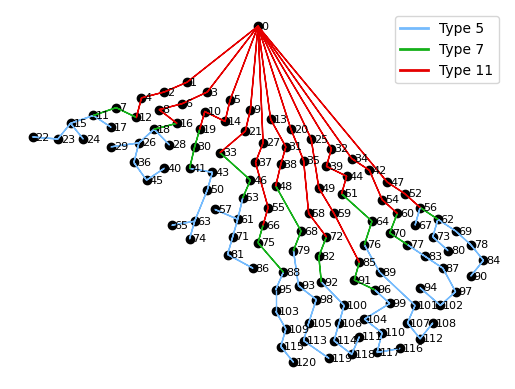

SWEEP COST: 90451850.75091593


In [ ]:
dist_matrix = create_dist_matrix(nodes)

sweep_flows, sweep_info_dict, sweep_cost = multi_sweep(nodes,cable_types,1)
plot_results(nodes,sweep_info_dict,None)
print("SWEEP COST:",sweep_cost)

In [ ]:

random.seed(time.time())

# Set up the folder path

output_path_images = "n120_s04_t03_w04/images/n120_s04_t03_w04_ex_10.png"
output_path_info = "n120_s04_t03_w04/infos/n120_s04_t03_w04_ex_10_info.txt"
output_path_cost = "n120_s04_t03_w04/costs/n120_s04_t03_w04_ex_10_cost.txt"

# Perform VNS with randomized local search and a time limit of 10 minutes

vns_info_dict,vns_cost = VNS(4,nodes,sweep_flows,sweep_info_dict,sweep_cost,dist_matrix,cable_types,crossing_edges)


# Save plot

#print("VNS COST:",vns_cost)
plot_results(nodes,vns_info_dict,output_path_images)

# Save info
with open(output_path_info, 'w') as f:
    f.write(str(vns_info_dict))

# Save cost
with open(output_path_cost, 'w') as f:
    f.write(str(vns_cost))





